<a href="https://colab.research.google.com/github/Nelimzzz/IS-Project/blob/main/IS_II.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#install Kaggle
!pip install -q kaggle

In [2]:
from google.colab import files 
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"lucynelima","key":"529ebdc1036dd44260f13ddf9889e69c"}'}

In [3]:
#creating a kaggle folder
! mkdir ~/.kaggle

In [4]:
#copy kaggle.json file into folder created 
! cp kaggle.json ~/.kaggle/

In [5]:
#Give permission for access
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
#list all datsets in kaggle
! kaggle datasets list

ref                                                         title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
----------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
akshaydattatraykhare/diabetes-dataset                       Diabetes Dataset                                      9KB  2022-10-06 08:55:25          17677        505  1.0              
akshaydattatraykhare/data-for-admission-in-the-university   Data for Admission in the University                  4KB  2022-10-27 11:05:45           4882        114  1.0              
thedevastator/jobs-dataset-from-glassdoor                   Salary Prediction                                     3MB  2022-11-16 13:52:31           1313         39  1.0              
meirnizri/covid19-dataset                                   COVID-19 Dataset    

In [7]:
!kaggle datasets download -d vbookshelf/rice-leaf-diseases

 68% 25.0M/36.7M [00:00<00:00, 44.5MB/s]
100% 36.7M/36.7M [00:00<00:00, 44.1MB/s]


In [8]:
!unzip rice-leaf-diseases.zip

Archive:  rice-leaf-diseases.zip
  inflating: rice_leaf_diseases/Bacterial leaf blight/DSC_0365.JPG  
  inflating: rice_leaf_diseases/Bacterial leaf blight/DSC_0366.jpg  
  inflating: rice_leaf_diseases/Bacterial leaf blight/DSC_0367.JPG  
  inflating: rice_leaf_diseases/Bacterial leaf blight/DSC_0370.jpg  
  inflating: rice_leaf_diseases/Bacterial leaf blight/DSC_0372.JPG  
  inflating: rice_leaf_diseases/Bacterial leaf blight/DSC_0373.JPG  
  inflating: rice_leaf_diseases/Bacterial leaf blight/DSC_0374.JPG  
  inflating: rice_leaf_diseases/Bacterial leaf blight/DSC_0375.JPG  
  inflating: rice_leaf_diseases/Bacterial leaf blight/DSC_0376.JPG  
  inflating: rice_leaf_diseases/Bacterial leaf blight/DSC_0377.JPG  
  inflating: rice_leaf_diseases/Bacterial leaf blight/DSC_0378.JPG  
  inflating: rice_leaf_diseases/Bacterial leaf blight/DSC_0379.JPG  
  inflating: rice_leaf_diseases/Bacterial leaf blight/DSC_0380.JPG  
  inflating: rice_leaf_diseases/Bacterial leaf blight/DSC_0381.JPG  
 

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!unzip gdrive/My\Drive/data/rice-leaf-diseases.zip

In [9]:
import tensorflow as tf
tf.__version__

'2.9.2'

In [10]:
import pandas as pd
import numpy as np
import os

import cv2

import albumentations as albu
from albumentations import Compose , ShiftScaleRotate , Resize
from albumentations.pytorch import ToTensorV2

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from sklearn.metrics import confusion_matrix
import itertools
from sklearn.metrics import classification_report

import shutil

import matplotlib.pyplot as plt
%matplotlib inline

In [11]:
IMAGE_HEIGHT = 224
IMAGE_WIDTH= 224
IMAGE_CHANNELS = 3

In [12]:
x = os.listdir('rice_leaf_diseases')
print (x)

['Brown spot', 'Leaf smut', 'Bacterial leaf blight']


In [13]:
from ctypes import alignment
#HELPER FUNCTIONS 
#plot and print confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize = False,
                          title='Confusion Matrix',
                          cmap=plt.cm.Blues):
  
  if normalize:
    cm = cm.astype('float') / cm.sum(axis=1) [:, np.newaxis]

    print("Normalized confusion matrix")
  else:
    print('Confusion Matrix , without normalization')
  print(cm)

  plt.imshow(cm,interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks=np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() /2.
  for i , j in itertools.product(range(cm.shape[0]) , range(cm.shape[1])):
    plt.text (j , i , format(cm[i,j],fmt),
              horizontalalignment = "center",
              color="white" if cm[i,j]>thresh else "black")
  
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.tight_layout()

Preparing the data


In [14]:
#Creating a dataframe containing all images 
leaf_smut_list = os.listdir('rice_leaf_diseases/Leaf smut')
brown_spot_list= os.listdir('rice_leaf_diseases/Brown spot')
bacterial_leaf_blight_list = os.listdir('rice_leaf_diseases/Bacterial leaf blight')

print(len(leaf_smut_list))
print(len(brown_spot_list))
print(len(bacterial_leaf_blight_list))


40
40
40


In [15]:
#create and train and value sets
df_leaf_smut = pd.DataFrame(leaf_smut_list, columns=['image'])
df_leaf_smut['target'] ='leaf smut'

df_brown_spot = pd.DataFrame(brown_spot_list, columns=['image'])
df_brown_spot['target'] = 'brown_spot'

df_bacterial_leaf_blight = pd.DataFrame(bacterial_leaf_blight_list, columns=['image'])
df_bacterial_leaf_blight['target'] = 'bacterial_leaf_blight'

#create a value set for each class and sample 5 validation images 
df_leaf_smut_val = df_leaf_smut.sample(n=5, random_state=101)
df_brown_spot_val = df_brown_spot.sample(n=5, random_state=101)
df_bacterial_leaf_blight_val = df_bacterial_leaf_blight.sample(n=5, random_state=101)

print(len(df_leaf_smut_val))
print(len(df_brown_spot_val))
print(len(df_bacterial_leaf_blight_val))

5
5
5


In [16]:
#Create the train set for each class, get list for val , filter them out
val_list = list(df_leaf_smut_val['image'])
#filter out value images 
df_leaf_smut_train= df_leaf_smut[~df_leaf_smut['image'].isin(val_list)]

#brown spot 
val_list = list(df_brown_spot_val['image'])

df_brown_spot_train = df_brown_spot[~df_brown_spot['image'].isin(val_list)]

#bacterial leaf blight 
val_list = list(df_bacterial_leaf_blight_val['image'])

df_bacterial_leaf_blight_train = df_bacterial_leaf_blight[~df_bacterial_leaf_blight['image'].isin(val_list)]

print(len(df_leaf_smut_train))
print(len(df_brown_spot_train))
print(len(df_bacterial_leaf_blight_train))

35
35
35


In [17]:
#create df_data , df_train and df_val
df_data = pd.concat([df_leaf_smut, df_brown_spot , df_bacterial_leaf_blight], axis=0).reset_index(drop=True)

df_train = pd.concat([df_leaf_smut_train, df_brown_spot_train , df_bacterial_leaf_blight_train], axis=0).reset_index(drop=True)

df_val = pd.concat([df_leaf_smut_val, df_brown_spot_val , df_bacterial_leaf_blight_val], axis=0).reset_index(drop=True)

df_data = shuffle(df_data)
df_train = shuffle(df_train)
df_val = shuffle(df_val)

print(df_data.shape)
print(df_train.shape)
print(df_val.shape)


(120, 2)
(105, 2)
(15, 2)


In [18]:
df_data['target'].value_counts()

leaf smut                40
brown_spot               40
bacterial_leaf_blight    40
Name: target, dtype: int64

In [19]:
df_train['target'].value_counts()

leaf smut                35
bacterial_leaf_blight    35
brown_spot               35
Name: target, dtype: int64

In [20]:
df_val['target'].value_counts()

bacterial_leaf_blight    5
brown_spot               5
leaf smut                5
Name: target, dtype: int64

Transform the targets (one hot encode)

In [21]:
#Create the target as index values

#combine value, train and test
val_len= len(df_val)
train_len=len(df_train)
df_combined = pd.concat(objs=[df_val, df_train], axis=0).reset_index(drop=True)

#create the dummy variables 
df_combined= pd.get_dummies(df_combined, columns=['target'])

#separate the train and value sets
df_val= df_combined[:val_len]
df_train= df_combined[val_len:]

print (df_train.shape)
print(df_val.shape)


(105, 4)
(15, 4)


In [22]:
df_combined.head()

,image,target_bacterial_leaf_blight,target_brown_spot,target_leaf smut
0,DSC_0701.jpg,1,0,0
1,DSC_0105.jpg,0,1,0
2,DSC_0306.JPG,0,1,0
3,DSC_0514.jpg,0,0,1
4,DSC_0113.jpg,0,1,0


In [23]:
df_train.head()

,image,target_bacterial_leaf_blight,target_brown_spot,target_leaf smut
15,DSC_0331.JPG,0,0,1
16,DSC_0384.JPG,1,0,0
17,DSC_0503.jpg,0,0,1
18,DSC_0110.jpg,0,1,0
19,DSC_0327.JPG,0,0,1


In [24]:
df_val.head()

,image,target_bacterial_leaf_blight,target_brown_spot,target_leaf smut
0,DSC_0701.jpg,1,0,0
1,DSC_0105.jpg,0,1,0
2,DSC_0306.JPG,0,1,0
3,DSC_0514.jpg,0,0,1
4,DSC_0113.jpg,0,1,0


Save the dataframes as compressed CSV files 

In [25]:
df_combined.to_csv('df_combined.csv.gz', compression='gzip', index=False)
df_train.to_csv('df_train.csv.gz', compression='gzip', index=False)
df_val.to_csv('df_val.csv.gz', compression='gzip', index=False)

In [26]:
!ls

df_combined.csv.gz  df_val.csv.gz  rice_leaf_diseases	   sample_data
df_train.csv.gz     kaggle.json    rice-leaf-diseases.zip


Move all images to the same folder 


In [27]:
#Create a new directory
image_dir = ' image_dir'
os.mkdir(image_dir)

!ls

 df_combined.csv.gz  ' image_dir'	   rice-leaf-diseases.zip
 df_train.csv.gz      kaggle.json	   sample_data
 df_val.csv.gz	      rice_leaf_diseases


In [28]:
leaf_smut_list = os.listdir('rice_leaf_diseases/Leaf smut')
brown_spot_list= os.listdir('rice_leaf_diseases/Brown spot')
bacterial_leaf_blight_list = os.listdir('rice_leaf_diseases/Bacterial leaf blight')

#Transfer the leaf smut images
for fname in leaf_smut_list:
  path = 'rice_leaf_diseases/Leaf smut'

  #source path to image and destnation path to img then cpy img from src to dest
  src = os.path.join(path,fname)
  dst = os.path.join(image_dir,fname)
  shutil.copyfile(src,dst)

#Transfer Brown spot images 
for fname in brown_spot_list:
  path = 'rice_leaf_diseases/Brown spot'

  src = os.path.join(path,fname)
  dst = os.path.join(image_dir,fname)
  shutil.copyfile(src,dst)

#Transfer the Bacterial Leaf Blight Images 
for fname in bacterial_leaf_blight_list:
  path = 'rice_leaf_diseases/Bacterial leaf blight'

  src = os.path.join(path,fname)
  dst = os.path.join(image_dir,fname)
  shutil.copyfile(src,dst)


In [29]:
len(os.listdir('/content/ image_dir'))

120

Display some images by class


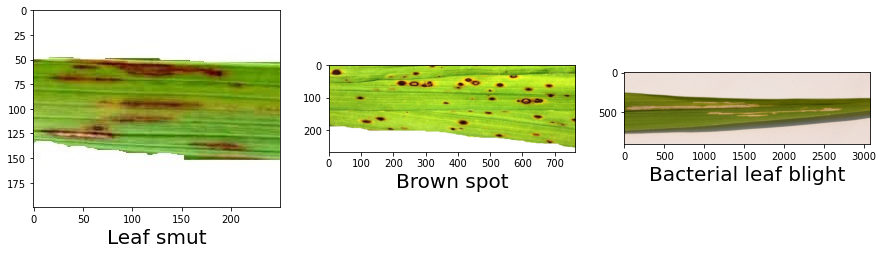

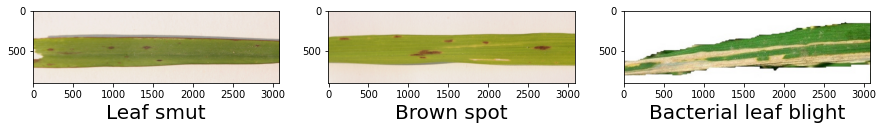

In [30]:
# set up the canvas for the subplots
plt.figure(figsize=(15,15))

# Image 1
plt.subplot(1,3,1)   # 1 row and 3 columns
item = 'DSC_0512.jpg'
path = '/content/rice_leaf_diseases/Leaf smut/' + item
image = plt.imread(path)
plt.imshow(image)
plt.xlabel('Leaf smut', fontsize=20)

# Image 2
plt.subplot(1,3,2)   # 1 row and 3 columns
item = 'DSC_0108.jpg'
path = '/content/rice_leaf_diseases/Brown spot/' + item
image = plt.imread(path)
plt.imshow(image)
plt.xlabel('Brown spot', fontsize=20)

# Image 2
plt.subplot(1,3,3)   # 1 row and 3 columns
item = 'DSC_0402.JPG'
path = '/content/rice_leaf_diseases/Bacterial leaf blight/' + item
image = plt.imread(path)
plt.imshow(image)
plt.xlabel('Bacterial leaf blight', fontsize=20)

# set up the canvas for the subplots
plt.figure(figsize=(15,15))

# Image 1
plt.subplot(1,3,1)   # 1 row and 3 columns
item = 'DSC_0316.JPG'
path = '/content/rice_leaf_diseases/Leaf smut/' + item
image = plt.imread(path)
plt.imshow(image)
plt.xlabel('Leaf smut', fontsize=20)

# Image 2
plt.subplot(1,3,2)   # 1 row and 3 columns
item = 'DSC_0303.JPG'
path = '/content/rice_leaf_diseases/Brown spot/' + item
image = plt.imread(path)
plt.imshow(image)
plt.xlabel('Brown spot', fontsize=20)

# Image 2
plt.subplot(1,3,3)   # 1 row and 3 columns
item = 'DSC_0702.jpg'
path = '/content/rice_leaf_diseases/Bacterial leaf blight/' + item
image = plt.imread(path)
plt.imshow(image)
plt.xlabel('Bacterial leaf blight', fontsize=20)

plt.show()

Set and test augmentations


In [31]:
#Albumentations 
import albumentations as albu

def augment_image(augmentation, image):
  #get the transformation as a dict
  aug_image_dict = augmentation(image=image)
  #retrieve the augmneted matrix of the image 
  image_matrix = aug_image_dict['image']

  return image_matrix


Define the transformations


In [32]:
aug_types = albu.Compose([
            albu.HorizontalFlip(),
              albu.OneOf([
                albu.HorizontalFlip(),
                albu.VerticalFlip(),
              ], p=0.8),
            albu.OneOf([
               albu.RandomBrightnessContrast(),
               albu.RandomGamma(),
               albu.RandomBrightnessContrast(), 
            ], p=0.3),
            albu.OneOf([
                albu.ElasticTransform(alpha=120, sigma =120*0.05, alpha_affine=120*0.03),
                albu.GridDistortion(),
                albu.OpticalDistortion(distort_limit=2, shift_limit=0.5),
            ], p=0.3),
            albu.ShiftScaleRotate()
])

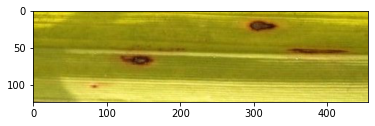

In [33]:
#Get an image to test transformations
#get a list of train png images 
path = '/content/ image_dir/'
image_list= os.listdir('/content/ image_dir/')

fname = image_list[1]
image_path = path + fname

image = plt.imread(image_path)
plt.imshow(image)

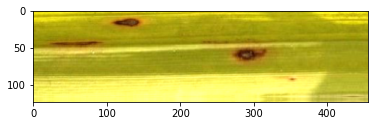

In [34]:
#Test the transformation setup
#The image will be different each the cell is run

aug_image = augment_image(aug_types , image)

plt.imshow(aug_image)

Build Data Generators

In [35]:
#Train Generator 
df_train.head()

,image,target_bacterial_leaf_blight,target_brown_spot,target_leaf smut
15,DSC_0331.JPG,0,0,1
16,DSC_0384.JPG,1,0,0
17,DSC_0503.jpg,0,0,1
18,DSC_0110.jpg,0,1,0
19,DSC_0327.JPG,0,0,1


In [36]:
def train_generator(batch_size=8):
  while True:
    #load the data in chunks(batches)
    for df in pd.read_csv('df_train.csv.gz', chunksize=batch_size):
      #get the list of images 
      image_id_list = list(df['image'])
      #create empty X matrix - 3 channels 
      X_train = np.zeros((len(df), IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS), dtype=np.uint8)

      #create X train
      for i in range(0, len(image_id_list)):
        #get the image and mask
        image_id = image_id_list[i]
        #set the path to the image 
        path = '/content/ image_dir/' + image_id
        #read the image 
        image = cv2.imread(path)
        #convert from BGR TO RGB
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        #resize the image 
        image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))

        #Create y train
        cols = ['target_bacterial_leaf_blight', 'target_brown_spot', 'target_leaf_smut']
        y_train = df[cols]
        y_train = np.asarray(y_train)

        aug_image = augment_image(aug_types, image)
        #insert image into X train
        X_train[i] = aug_image

      #normalize the images 
      X_train = X_train/255

      yield X_train, y_train

In [ ]:
#test the generator
#initialize 
train_gen = train_generator(batch_size=8)

#run it 
X_train , y_train = next(train_gen)

print(X_train.shape)
print(y_train.shape)

KeyError: ignored